# WGCNA using parameters

Below is some demonstration data, that takes the parameters for each individual fitted from a common negative binomial model (meaning they all have the same dispersion parameter). This can be probably to expression data directly. This notebook will be a tutorial about how to identify gene modules (where they can be identified).

In [ ]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append("../src")
df = pd.read_csv("../data/data.csv").set_index("specimen").drop("group", axis=1).T

# To remove those with too small of values
df = df.loc[df.min(axis=1) > -10]

In [97]:
import topology
import activation
import clustering
import correlation
import utilities

import importlib
importlib.reload(topology)
importlib.reload(utilities)
importlib.reload(activation)
importlib.reload(clustering)
importlib.reload(correlation)

<module 'correlation' from '/Users/jameshaberberger/GitHub/pywgcna/example/../src/correlation.py'>

Here, we compute the shrunk covariance matrix using the Ledoit-Wolf estimator, find the scale free power, and compute the Topological Overlap Matrix (measure of graph similarity).

In [159]:
corr = correlation.compute_shrunk_correlation(df.T)

sf_power = topology.find_scale_free_power(
    activation.strictly_positive_activation(corr)
)

TOM = pd.DataFrame(
    topology.topological_overlap(np.power(activation.strictly_positive_activation(corr), sf_power)),
    index=df.index,
    columns=df.index
)

Power: 1, R^2: 0.16026281312026605
Power: 2, R^2: 0.7896350486515918
Power: 3, R^2: 0.9614165999310181


<Axes: ylabel='Frequency'>

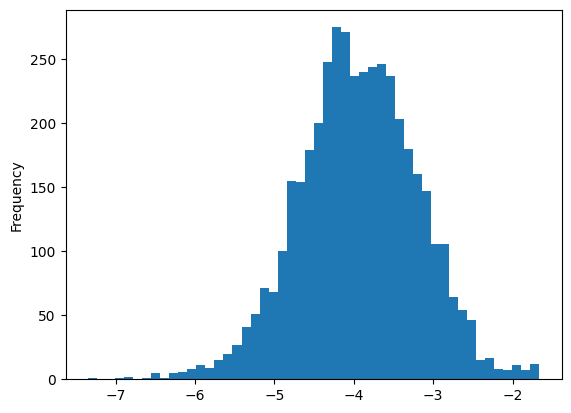

In [160]:
import sklearn.mixture

identifying_spurious_correlations = pd.DataFrame({
    "group": sklearn.mixture.GaussianMixture(n_components=2).fit_predict(pd.Series(TOM.max(axis=0), index=df.index).apply(np.log).values.reshape(-1, 1)).tolist(),
    "max_log_corr": pd.Series(TOM.max(axis=0), index=df.index).apply(np.log)
})

identifying_spurious_correlations["max_log_corr"].plot.hist(bins=50)

In [230]:
spurious_correlations = pd.Series(TOM.max(axis=0), index=df.index).apply(np.log).between(-2.5, 0)

TOM = TOM.loc[spurious_correlations, spurious_correlations]

In [231]:
labels = clustering.spectral_clustering_method(TOM)

100%|██████████| 19/19 [00:00<00:00, 187.61it/s]

2 61.9217235856892
3 57.818324774866525
4 74.7319898762627
5 98.47012909262601
6 75.02099035119699
7 70.50261841088704
8 56.49765274698972
9 49.21472740575869
10 51.27982711267666
11 48.32155116286844
12 40.5421626419214
13 39.99332523691919
14 34.285316113183185
15 32.8529888970247
16 32.68241067119802
17 27.881274026411266
18 24.617952176542722
19 30.617811074057553
20 23.44986433851542
Optimal number of clusters: 5 with Calinski-Harabasz score: 98.47012909262601


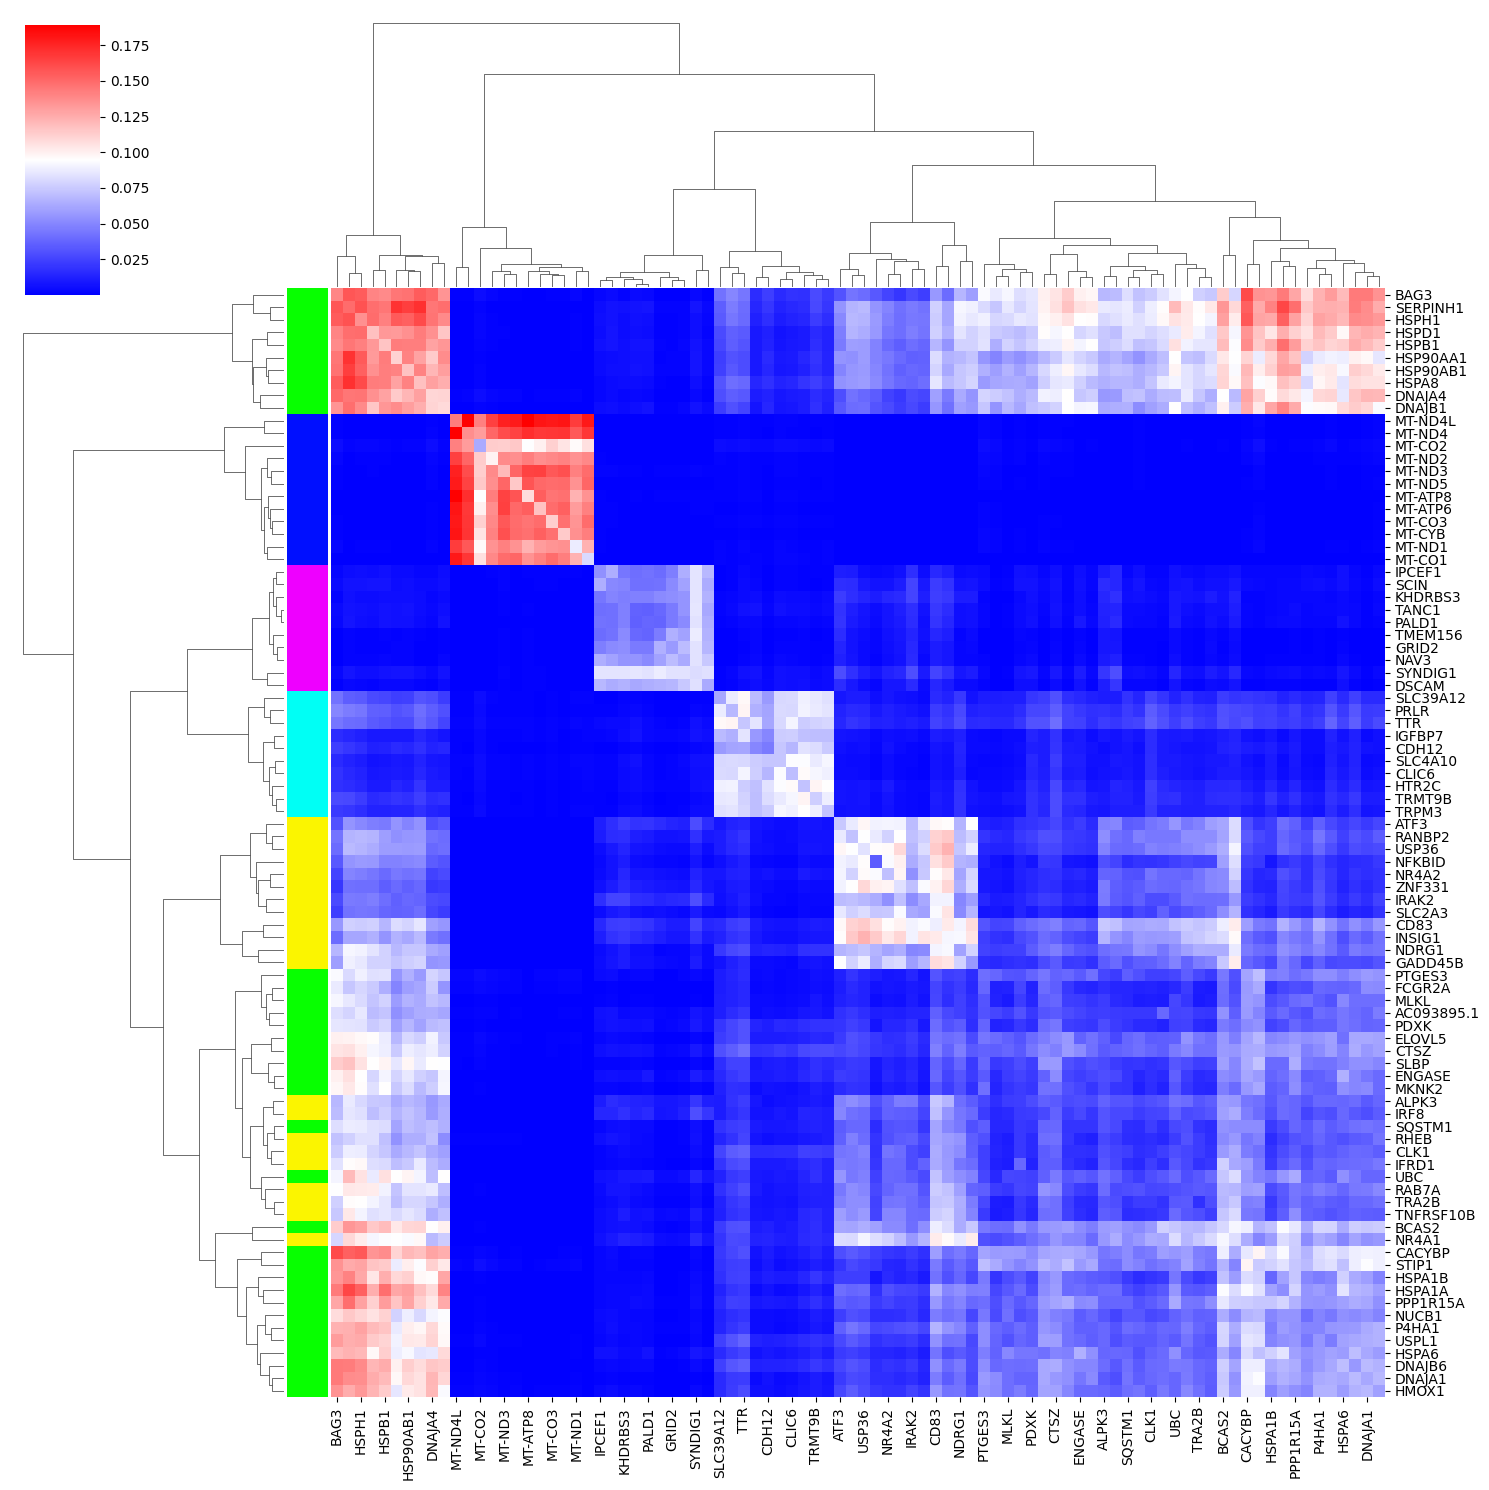

In [234]:
sns.clustermap(
    TOM,
    yticklabels=True,
    figsize=(15, 15),
    row_colors=utilities.labels_to_hex_colors(labels),
    method="complete",
    cmap="bwr"
)

# To confirm these genes really do correlate with one another.

In [ ]:
table = df.T.reset_index()
table["group"] = table.specimen.str[8]

sns.pairplot(table.loc[:, TOM[labels==0].index])

KeyboardInterrupt: 

TtestResult(statistic=1.42781336176756, pvalue=0.17900327797961374, df=11.926552823489624)

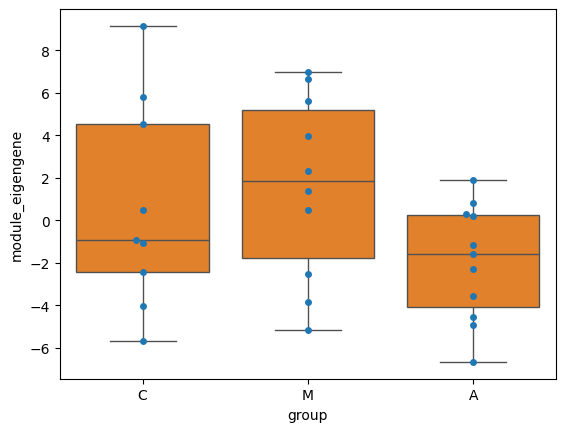

In [ ]:
import scipy.stats
from sklearn.decomposition import PCA

module_number = 2

eigengene_scores = pd.DataFrame({
    "group": table.specimen.str[8],
    "module_eigengene": PCA(n_components=1).fit_transform(table.loc[:, TOM[labels==module_number].index]).reshape(-1)
})

sns.swarmplot(
    eigengene_scores, 
    x="group",
    y="module_eigengene",
)
sns.boxplot(
    eigengene_scores, 
    x="group",
    y="module_eigengene",
)

scipy.stats.ttest_ind(
    eigengene_scores.loc[eigengene_scores.group == "C"].module_eigengene,
    eigengene_scores.loc[eigengene_scores.group == "A"].module_eigengene,
    equal_var=False
)

In [229]:
" ".join(TOM[labels==1].index)

'BCAS2 FCGR2A HSPA6 CACYBP HSPD1 SLBP AC093895.1 SQSTM1 HSPA1A HSPA1B HSP90AB1 ELOVL5 HSPB1 DNAJB6 DNAJA1 P4HA1 BAG3 STIP1 SERPINH1 HSPA8 PTGES3 UBC USPL1 HSPH1 HSP90AA1 DNAJA4 MLKL ENGASE MKNK2 DNAJB1 PPP1R15A NUCB1 CTSZ PDXK HMOX1'